# Import Libraries

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from datetime import date
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import functional as F
from torch import nn, optim

from rdkit import Chem
import selfies as sf

In [2]:
# import chemVAE functions
from chemVAE import main

# One-Hot Encode SMILES Data


In [3]:
# load dataset
df = pd.read_csv('opv_molecules.csv')

# select SMILEs data
smiles = df['SMILES'].values

In [4]:
selfies = main.smiles2selfies(smiles) 

In [5]:
onehot_selfies, idx_to_symbol = main.onehotSELFIES(selfies)

# Load One-Hot Encoded Data into Pytorch Dataset

In [6]:
# split data in training and testing
X_train, X_test, y_train, y_test = train_test_split(onehot_selfies, onehot_selfies, test_size = 0.40)
X_test, X_val, y_test, y_val = train_test_split(X_test, X_test, test_size = 0.50)

In [7]:
# Pytroch Dataset
train_data = main.SELFIES_Dataset(X_train, y_train, transform = transforms.ToTensor())
test_data = main.SELFIES_Dataset(X_test, y_test, transform = transforms.ToTensor())
val_data = main.SELFIES_Dataset(X_val, y_val, transform = transforms.ToTensor())

# Set Model Parameters

In [39]:
num_characters, max_seq_len = onehot_selfies[0].shape
params = {'num_conv_layers' : 3,
             'layer1_filters' : num_characters,
             'layer2_filters' : num_characters,
             'layer3_filters' : num_characters,
             'layer4_filters' : num_characters,
             'kernel1_size' : 11,
             'kernel2_size' : 11,
             'kernel3_size' : 11,
             'kernel4_size' : 11,
             'lstm_stack_size' : 3,
             'lstm_num_neurons' : 396,
             'latent_dimensions' : 256,
             'batch_size' : 256,
             'epochs' : 500,
             'learning_rate' : 10**-4,
             'KLD_anneal_start' : 100,
             'KLD_anneal_stop': 300,
             'KLD_cycle_steps': 500,
             'KLD_n_cycles' : 4}

# Train Model

In [40]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training Model on: " + str(device))

# load data
train_loader = DataLoader(train_data, batch_size = params['batch_size'], shuffle = True)
test_loader = DataLoader(test_data, batch_size = params['batch_size'], shuffle = True)

# initialize model
model = main.VAE(num_characters, max_seq_len, params).to(device)

# set optimizer
optimizer = optim.Adam(model.parameters(), lr = params['learning_rate'])

# set KL annealing
KLD_alpha = np.zeros(params['epochs'])
KLD_alpha[params['KLD_anneal_start']:params['KLD_anneal_stop']] = np.linspace(0,1, params['KLD_anneal_stop'] - params['KLD_anneal_start'])
KLD_alpha[params['KLD_anneal_stop']::] = 1

## generate unique filenames
date = date.today()
now = datetime.now()
time = now.strftime("%H%M%S")
model_filename = "model_" + str(date) + "_" + str(time) +'.pth'

Training Model on: cuda


In [41]:
# train model
epoch = params['KLD_cycle_steps']*params['KLD_n_cycles']
train_loss = []
test_loss = []
BCE_loss = []
KLD_loss = []
KLD_weight = []
for epoch in range(1,  epoch + 1):
        alpha = KLD_alpha[epoch-1]
        loss, BCE, KLD_wt, KLD = main.train(model, train_loader, optimizer, device, epoch, alpha)
        train_loss.append(loss)
        BCE_loss.append(BCE)
        KLD_loss.append(KLD)
        KLD_weight.append(KLD_wt)
        
        test_loss.append(main.test(model, test_loader, optimizer, device, epoch, alpha))    
        
# save model
torch.save(model, model_filename)
print("Saved PyTorch Model State to " + model_filename)

====> Epoch: 1 Average loss: 0.00878
====> Test set loss: 0.00734


KeyboardInterrupt: 

# Deploy Model

In [43]:
# load trained model
model = torch.load(model_filename) 

# load pretrained test model
model = torch.load('pretrained_model.pth') 

In [44]:
# grab random sample from test_data
sample_idx = np.random.randint(0,len(test_data)-1)
img, label = train_data[sample_idx]

# run model
with torch.no_grad():
        img = img.to(device)
        recon_data, z, mu, logvar = model(img)
recon_data = recon_data[0].cpu()

# grab original smiles
sample = img[0].cpu().numpy()
char_ind = list(np.argmax(sample.squeeze(),axis=0))
string = [idx_to_symbol[i] for i in char_ind]
selfie = ''.join(string)
smiles = sf.decoder(selfie)

# reconstructed smiles
recon_sample = recon_data.numpy()
char_ind = list(np.argmax(recon_sample.squeeze(),axis=0))
string = [idx_to_symbol[i] for i in char_ind]
recon_selfie = ''.join(string)
recon_smiles = sf.decoder(recon_selfie)

Text(0.5, 1.0, 'Reconstruction')

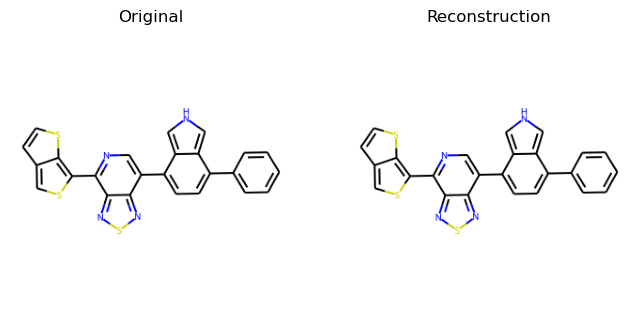

In [45]:
# visualize model reconstruction

## draw molecule and reconstruction
m1 = Chem.MolFromSmiles(smiles)
Draw.MolToFile(m1,'original.png') 

m2 = Chem.MolFromSmiles(recon_smiles)
Draw.MolToFile(m2,'reconstruct.png') 

## visualize molecules in notebokk
figure(figsize=(8, 6), dpi = 100)
plt.subplot(1,2,1)
img = mpimg.imread('original.png')
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1,2,2)
img = mpimg.imread('reconstruct.png')
plt.imshow(img)
plt.axis('off')
plt.title('Reconstruction')